In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acovf
from sklearn.neural_network import MLPRegressor
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.stats as sms
from statsmodels.tsa.stattools import acovf
from sklearn.metrics import mean_squared_error as MSE
import seaborn as sns
sns.set()

from matplotlib.pylab import rcParams
from sklearn.metrics import mean_squared_error

In [2]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh', title = 'Time Series Analysis Plots'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        plt.tight_layout()
    return

# Dado Diário

In [3]:
data = pd.read_csv('data.csv', header=None)

Como ilustrado abaixo, os 13 primeiros lags apresentam autocorrelação significante. Logo, a entrada da rede neural apresentará, no máximo, 14 entradas que representam os valores antecessores ao que se quer prever.

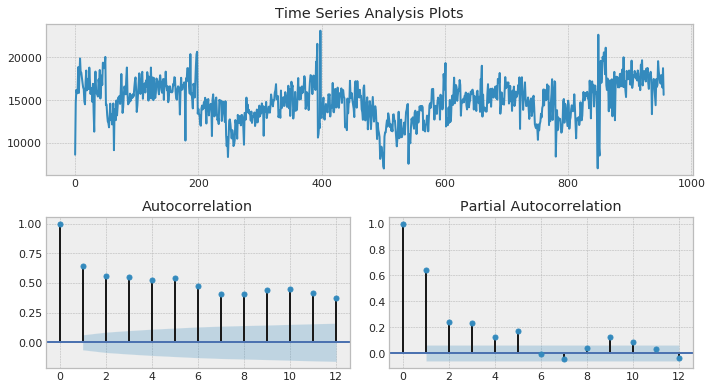

In [4]:
rcParams['figure.figsize'] = 15, 6
max_lag = 12
_ = tsplot(data.iloc[:,0].values, lags=max_lag)
data = data.values

# Funções

In [5]:
def normalizar_serie(serie):
    minimo = min(serie)
    maximo = max(serie)
    y = (serie - minimo) / (maximo - minimo)
    return y

In [6]:
def desnormalizar(serie_atual, serie_real):
    minimo = min(serie_real)
    maximo = max(serie_real)
    
    serie = (serie_atual * (maximo - minimo)) + minimo
    
    return pd.DataFrame(serie)

In [7]:
def gerar_janelas(tam_janela, serie):
    # serie: vetor do tipo numpy ou lista
    tam_serie = len(serie)
    tam_janela = tam_janela +1 # Adicionado mais um ponto para retornar o target na janela
    
    janela = list(serie[0:0+tam_janela]) #primeira janela p criar o objeto np
    janelas_np = np.array(np.transpose(janela))    
       
    for i in range(1, tam_serie-tam_janela):  #começa do 1 
        janela = list(serie[i:i+tam_janela])
        j_np = np.array(np.transpose(janela))        
        
        janelas_np = np.vstack((janelas_np, j_np))
        
    
    return janelas_np

In [8]:
def select_lag_acf(serie, max_lag):
    from statsmodels.tsa.stattools import acf
    x = serie[0: max_lag+1]
    
    acf_x, confint = acf(serie, nlags=max_lag, alpha=.05, fft=False,
                             unbiased=False)
       
    limiar_superior = confint[:, 1] - acf_x
    limiar_inferior = confint[:, 0] - acf_x
    
    lags_selecionados = []
    
    for i in range(1, max_lag+1):

        
        if acf_x[i] >= limiar_superior[i] or acf_x[i] <= limiar_inferior[i]:
            lags_selecionados.append(i-1)  #-1 por conta que o lag 1 em python é o 0
    
    #caso nenhum lag seja selecionado, essa atividade de seleção para o gridsearch encontrar a melhor combinação de lags
    if len(lags_selecionados)==0:


        print('NENHUM LAG POR ACF')
        lags_selecionados = [i for i in range(max_lag)]

    print('LAGS', lags_selecionados)

    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    #inverte o valor dos lags para usar na lista de dados se os dados forem de ordem [t t+1 t+2 t+3]
    lags_selecionados = [max_lag - (i+1) for i in lags_selecionados]
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

    return lags_selecionados

In [9]:
def split_serie_with_lags(serie, perc_train, perc_val = 0):
    
    #faz corte na serie com as janelas já formadas 
    
    x_date = serie[:, 0:-1]
    y_date = serie[:, -1]        
       
    train_size = np.fix(len(serie) *perc_train)
    train_size = train_size.astype(int)
    
    if perc_val > 0:        
        val_size = np.fix(len(serie) *perc_val).astype(int)
              
        
        x_train = x_date[0:train_size,:]
        y_train = y_date[0:train_size]
        print("Particao de Treinamento:", 0, train_size  )
        
        x_val = x_date[train_size:train_size+val_size,:]
        y_val = y_date[train_size:train_size+val_size]
        
        print("Particao de Validacao:",train_size, train_size+val_size)
        
        x_test = x_date[(train_size+val_size):-1,:]
        y_test = y_date[(train_size+val_size):-1]
        
        print("Particao de Teste:", train_size+val_size, len(y_date))
        
        return x_train, y_train, x_test, y_test, x_val, y_val
        
    else:
        
        x_train = x_date[0:train_size,:]
        y_train = y_date[0:train_size]

        x_test = x_date[train_size:-1,:]
        y_test = y_date[train_size:-1]

        return x_train, y_train, x_test, y_test

In [76]:
def treinar_mlp(x_train, y_train, x_val, y_val, num_exec, func_activation):
    
    
    neuronios =  [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    alg_treinamento = ['lbfgs','adam']
    max_iteracoes = 10000
    learning_rate = ['adaptive', 'constant']
    qtd_lags_sel = len(x_train[0])
    best_result = np.Inf
    for i in range(0,len(neuronios)):
        for l in range(0,len(alg_treinamento)):
            for n in range(0,len(learning_rate)):
                for qtd_lag in range(1, len(x_train[0]+1)): #variando a qtd de pontos utilizados na janela 

#                     print('QTD de Lags:', qtd_lag, 'Qtd de Neuronios' ,neuronios[i], 'Func. Act', func_activation)


                    for e in range(0,num_exec):
                        mlp = MLPRegressor(hidden_layer_sizes=neuronios[i], activation=func_activation, solver=alg_treinamento[l], max_iter = max_iteracoes, learning_rate= learning_rate[n])
                        
                        mlp.fit(x_train[:,-qtd_lag:], y_train)
                        predict_validation = mlp.predict(x_val[:,-qtd_lag:])
                        mse = MSE(y_val, predict_validation)

                        if mse < best_result:
                            best_hidden = i
                            best_alg = l
                            best_rate = n
                            best_result = mse
                            select_model = mlp
                            qtd_lags_sel = qtd_lag

    print('Neurônios de entrada:',qtd_lags_sel)
    print('Neurônios da camada oculta:',neuronios[best_hidden])
    print('Algoritmo de treinamento:',alg_treinamento[best_alg])
    print('Taxa de aprendizagem:',learning_rate[best_rate])
    print('Melhor MSE:', best_result)
    return select_model, qtd_lags_sel

In [26]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 1) Análise de resultados

In [27]:
serie_normalizada = normalizar_serie(data)
janelas = gerar_janelas(10, serie_normalizada)

In [28]:
serie_normalizada[:5]

array([[0.10060976],
       [0.47890742],
       [0.57061971],
       [0.54448731],
       [0.56054007]])

In [29]:
x_train, y_train, x_test, y_test, x_val, y_val = split_serie_with_lags(janelas, 0.60, perc_val = 0.20)

Particao de Treinamento: 0 567
Particao de Validacao: 567 756
Particao de Teste: 756 945


O conjunto de treinamento equivale a 60% da série, enquanto os conjuntos de validação e teste equivalem a 20% cada.

In [30]:
model, lag_sel = treinar_mlp(x_train, y_train, x_val, y_val, 5, 'tanh')

Neurônios de entrada: 4
Neurônios da camada oculta: 10
Algoritmo de treinamento: lbfgs
Taxa de aprendizagem: adaptive
Melhor MSE: 0.00677029026622554


In [31]:
predict_test = model.predict(x_test[:, -lag_sel:])

In [32]:
y_desn = desnormalizar(y_test, data)
pred_desn = desnormalizar(predict_test, data)

Text(0.5,1,'Previsão de Demanda Diária')

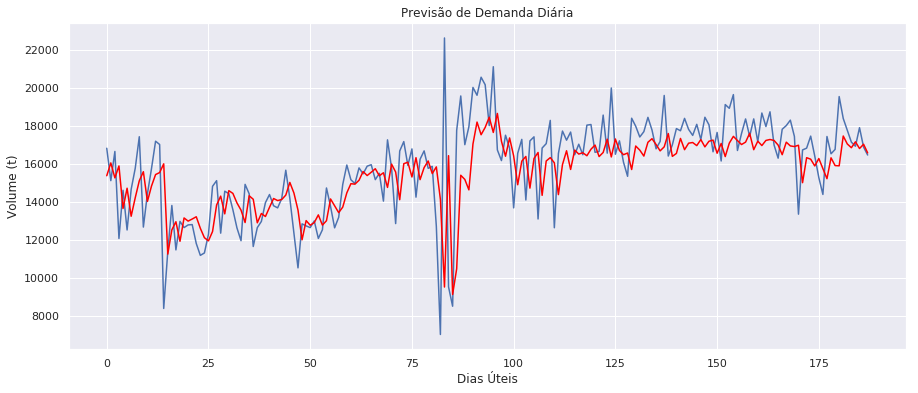

In [42]:
plt.plot(y_desn)
plt.plot(pred_desn, color = 'red')
plt.xlabel('Dias Úteis')
plt.ylabel('Volume (t)')
plt.title('Previsão de Demanda Diária')

In [43]:
trechos = int(len(y_desn)/20)
for i in range(trechos):
    results = mean_absolute_percentage_error(y_desn[i*20:(i+1)*20], pred_desn[i*20:(i+1)*20])
    print('Intervalo:',i*20,'-',(i+1)*20,'MAPE:',results)

Intervalo: 0 - 20 MAPE: 14.368521214364952
Intervalo: 20 - 40 MAPE: 8.186619898898996
Intervalo: 40 - 60 MAPE: 6.799022824649778
Intervalo: 60 - 80 MAPE: 6.23991071842365
Intervalo: 80 - 100 MAPE: 22.499337763852488
Intervalo: 100 - 120 MAPE: 10.828788646157342
Intervalo: 120 - 140 MAPE: 6.263661803774098
Intervalo: 140 - 160 MAPE: 5.876981750829289
Intervalo: 160 - 180 MAPE: 6.7505974716002894


# Dado Semanal

In [59]:
semana = pd.read_csv('data_week.csv', header=None)

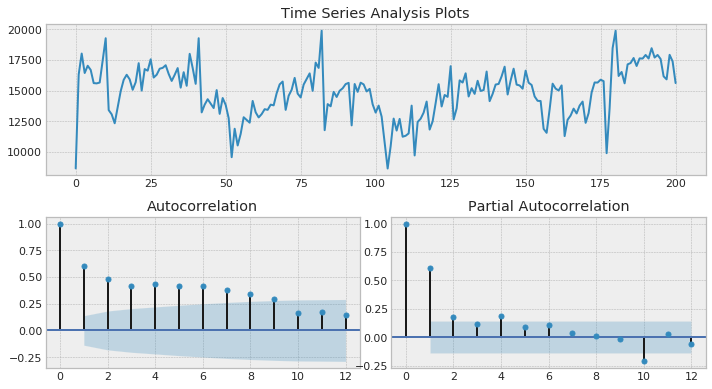

In [60]:
rcParams['figure.figsize'] = 15, 6
max_lag = 12
_ = tsplot(semana.iloc[:,0].values, lags=max_lag)
semana = semana.values

In [61]:
semana_normalizada = normalizar_serie(semana)
janelas_sem = gerar_janelas(10, semana_normalizada)
print(janelas_sem)

[[6.21504040e-04 6.81878718e-01 8.34235994e-01 ... 6.23812483e-01
  7.84249312e-01 9.45218858e-01]
 [6.81878718e-01 8.34235994e-01 6.92977004e-01 ... 7.84249312e-01
  9.45218858e-01 4.23865755e-01]
 [8.34235994e-01 6.92977004e-01 7.45627275e-01 ... 9.45218858e-01
  4.23865755e-01 3.92968126e-01]
 ...
 [7.43940336e-01 7.99076623e-01 7.97656042e-01 ... 7.94548522e-01
  6.68827133e-01 6.46896919e-01]
 [7.99076623e-01 7.97656042e-01 8.23847998e-01 ... 6.68827133e-01
  6.46896919e-01 8.24913433e-01]
 [7.97656042e-01 8.23847998e-01 7.98099973e-01 ... 6.46896919e-01
  8.24913433e-01 7.77146409e-01]]


In [62]:
X_train, Y_train, X_test, Y_test, X_val, Y_val = split_serie_with_lags(janelas_sem, 0.60, perc_val = 0.20)

Particao de Treinamento: 0 114
Particao de Validacao: 114 152
Particao de Teste: 152 190


In [49]:
model_sem, lag_sel_sem = treinar_mlp(X_train, Y_train, X_val, Y_val, 5, 'tanh')

Neuro 0
Neuro 1
Neuro 2
Neuro 3
Neuro 4
Neuro 5
Neuro 6
Neuro 7
Neuro 8
Neuro 9
Neuro 10
Neurônios de entrada: 5
Neurônios da camada oculta: 40
Algoritmo de treinamento: lbfgs
Taxa de aprendizagem: adaptive
Melhor MSE: 0.010505367665822956


In [63]:
predict_test_sem = model_sem.predict(X_test[:, -lag_sel_sem:])

In [64]:
predict_test_sem

array([0.51491632, 0.57868181, 0.27189233, 0.33261727, 0.41418853,
       0.43183864, 0.42332701, 0.45597336, 0.48499905, 0.36644652,
       0.41419779, 0.49932601, 0.53615297, 0.52902433, 0.5820456 ,
       0.65624327, 0.25850392, 0.39939634, 0.41098421, 0.09704743,
       0.60688731, 0.63476513, 0.71220814, 0.82059898, 0.76023475,
       0.74680499, 0.76568043, 0.79786305, 0.83347314, 0.83335193,
       0.83194222, 0.81844568, 0.87634785, 0.85641431, 0.86387715,
       0.77266612, 0.72615283])

In [68]:
Y_desn = desnormalizar(Y_test, semana)
Pred_desn = desnormalizar(predict_test_sem, semana)


Text(0.5,1,'Previsão de Demanda Semanal')

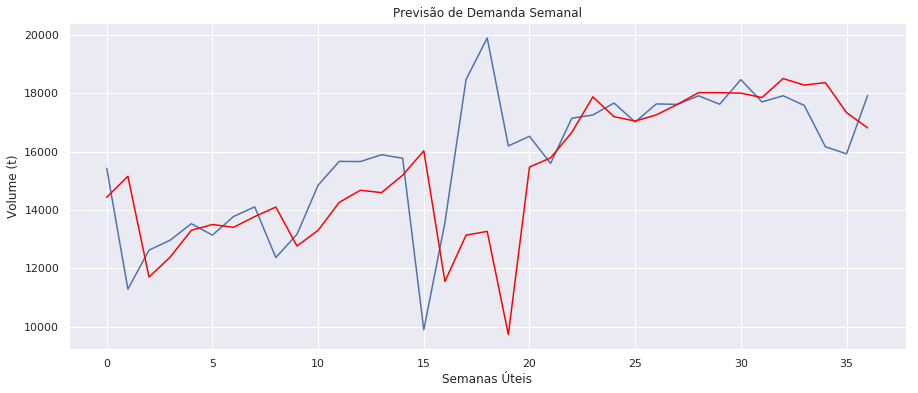

In [74]:
plt.plot(Y_desn)
plt.plot(Pred_desn, color = 'red')
plt.xlabel('Semanas Úteis')
plt.ylabel('Volume (t)')
plt.title('Previsão de Demanda Semanal')

In [75]:
trechos = int(len(Y_desn)/4)
for i in range(trechos):
    results = mean_absolute_percentage_error(Y_desn[i*4:(i+1)*4], Pred_desn[i*4:(i+1)*4])
    print('Intervalo:',i*4,'-',(i+1)*4,'MAPE:',results)

Intervalo: 0 - 4 MAPE: 13.118573000476182
Intervalo: 4 - 8 MAPE: 2.379203114086505
Intervalo: 8 - 12 MAPE: 9.105452879147952
Intervalo: 12 - 16 MAPE: 20.04953528514211
Intervalo: 16 - 20 MAPE: 29.261312843621113
Intervalo: 20 - 24 MAPE: 3.5091221234052976
Intervalo: 24 - 28 MAPE: 1.2452509105072018
Intervalo: 28 - 32 MAPE: 1.5499958360047548
Intervalo: 32 - 36 MAPE: 7.433848412098606
